# Tổ chức data Diff-Palm

## Thư viện cần thiết

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm

## Xử lý data

In [2]:
INPUT_ROOT = "/kaggle/input/dataset-40000-new/dataset_40000_new"
OUTPUT_DIR = "/kaggle/working/dataset_diff_palm"
TARGET_FILENAME = "samples_400x128x128x3.npz"

SOURCE_IMGS_PER_ID = 20   
TAKE_IMGS_PER_ID = 10     
TARGET_TOTAL_IDS = 1200

def process_nested_dataset():
    if not os.path.exists(INPUT_ROOT):
        print(f"Không tìm thấy đường dẫn {INPUT_ROOT}")
        return

    # Reset thư mục đầu ra
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    
    os.makedirs(OUTPUT_DIR)

    # Lấy danh sách thư mục con và sắp xếp theo số
    subfolders = [f for f in os.listdir(INPUT_ROOT) if f.startswith("data_") and os.path.isdir(os.path.join(INPUT_ROOT, f))]
    
    try:
        subfolders.sort(key=lambda x: int(x.split('_')[1]))
    except:
        print("Tên thư mục không chuẩn định dạng 'data_Start_End'.")


    total_images_saved = 0
    processed_ids = set()

    for folder_name in tqdm(subfolders, desc="Processing"):
        
        if len(processed_ids) >= TARGET_TOTAL_IDS:
            break

        folder_path = os.path.join(INPUT_ROOT, folder_name)

        # Lấy ID bắt đầu từ tên folder (VD: data_0_19 -> start=0)
        try:
            parts = folder_name.split('_') 
            start_node_id = int(parts[1])
        except:
            continue

        npz_path = os.path.join(folder_path, TARGET_FILENAME)
        if not os.path.exists(npz_path):
            continue

        try:
            data = np.load(npz_path)
            key = list(data.keys())[0]
            images = data[key] 
        except Exception as e:
            print(f"Lỗi đọc file: {e}")
            continue

        # DUYỆT QUA TỪNG ẢNH TRONG BATCH
        for i in range(images.shape[0]):
            
            offset_id = i // SOURCE_IMGS_PER_ID 
            
            img_index_for_person = i % SOURCE_IMGS_PER_ID
            
            if img_index_for_person >= TAKE_IMGS_PER_ID:
                continue

            global_id = start_node_id + offset_id

            if global_id >= TARGET_TOTAL_IDS:
                continue

            img_array = images[i]
            if img_array.dtype != np.uint8:
                if img_array.max() <= 1.0: 
                    img_array = (img_array * 255).astype(np.uint8)
                else:
                    img_array = img_array.astype(np.uint8)

            target_id_folder = os.path.join(OUTPUT_DIR, f"id_{global_id:04d}")
            os.makedirs(target_id_folder, exist_ok=True)
            
            processed_ids.add(global_id)

            save_filename = f"{folder_name}_{i}.png"
            Image.fromarray(img_array).save(os.path.join(target_id_folder, save_filename))
            
            total_images_saved += 1

    print(f"\nHOÀN TẤT XỬ LÝ!")

process_nested_dataset()

Processing:  60%|██████    | 60/100 [01:43<01:09,  1.73s/it]


HOÀN TẤT XỬ LÝ!


## Xem thử vài mẫu

In [3]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [4]:
def show_random_samples(DATA_DIR, NUM_IDS_TO_SHOW = 3, SAMPLES_PER_ID = 5):
    if not os.path.exists(DATA_DIR):
        print(f"Không tìm thấy thư mục: {DATA_DIR}")
        return

    # Lấy danh sách tất cả các folder ID
    all_ids = sorted([d for d in os.listdir(DATA_DIR) if d.startswith("id_")])
    
    if not all_ids:
        print("Thư mục rỗng!")
        return


    selected_ids = random.sample(all_ids, min(len(all_ids), NUM_IDS_TO_SHOW)) 
    
    print(f"Đang hiển thị mẫu cho các ID: {selected_ids}")

    # Thiết lập khung hình
    fig, axes = plt.subplots(NUM_IDS_TO_SHOW, SAMPLES_PER_ID, figsize=(15, 3 * NUM_IDS_TO_SHOW))
    
    # Xử lý trường hợp chỉ hiển thị 1 dòng để tránh lỗi vòng lặp
    if NUM_IDS_TO_SHOW == 1: 
        axes = [axes]

    for row_idx, id_name in enumerate(selected_ids):
        id_path = os.path.join(DATA_DIR, id_name)
        
        # Lấy danh sách ảnh trong folder ID đó
        images = [f for f in os.listdir(id_path) if f.endswith(('.png', '.jpg'))]
        
        if not images:
            continue
            
        # Chọn ngẫu nhiên các ảnh con
        selected_imgs = random.sample(images, min(len(images), SAMPLES_PER_ID))
        
        for col_idx, img_name in enumerate(selected_imgs):
            img_path = os.path.join(id_path, img_name)
            
            try:
                img = Image.open(img_path)
                
                ax = axes[row_idx][col_idx] if NUM_IDS_TO_SHOW > 1 else axes[col_idx]
                
                ax.imshow(img, cmap='gray')
                ax.axis('off') # Tắt trục tọa độ
                
                if col_idx == 0:
                    ax.set_title(f"{id_name}\n({len(images)} ảnh)", fontsize=12, fontweight='bold', loc='left')
                    
            except Exception as e:
                print(f"Lỗi không mở được ảnh {img_path}: {e}")

    plt.tight_layout()
    plt.show()

Đang hiển thị mẫu cho các ID: ['id_1151', 'id_0552', 'id_0149']


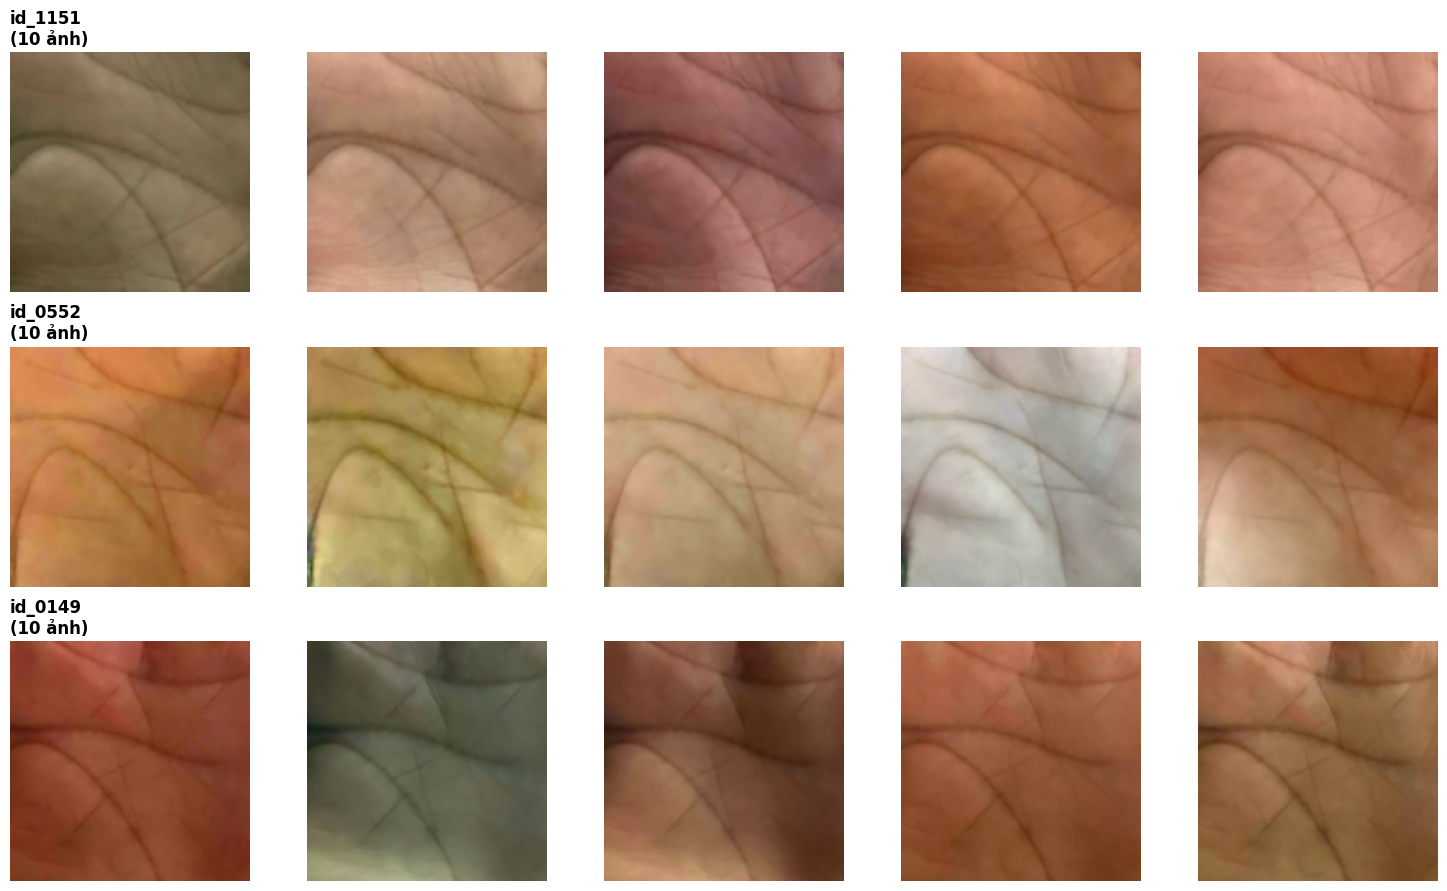

In [5]:
show_random_samples("/kaggle/working/dataset_diff_palm")

# Cài đặt mô hình

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import os
import math
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

## Backbone Modified ResNet-18

In [7]:
class ModifiedResNet18(nn.Module):
    def __init__(self, embedding_size=512, dropout_prob=0):
        super(ModifiedResNet18, self).__init__()
        self.model = models.resnet18(weights="DEFAULT") 
        
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        
        # Embedding Layer
        self.model.fc = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x

## ArcFace Head

In [8]:
class ArcFaceHead(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFaceHead, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # Khởi tạo các hằng số toán học
        self.update_margin(m)

    # Hàm hỗ trợ cập nhật margin động (cho Warmup)
    def update_margin(self, m):
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embedding, label):
        cosine = F.linear(F.normalize(embedding), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        one_hot = torch.zeros(cosine.size(), device=embedding.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# Huấn luyện mô hình

## Đối với dữ liệu sinh ra từ Diff-Palm

In [9]:
DIFF_PALM_CONFIG = {
    "name":"diff-palm",
    "data_dir": "/kaggle/working/dataset_diff_palm", 
    "image_size": 112,
    "batch_size": 256,    
    "lr": 0.1,            
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "epochs": 40,
    "milestones": [15, 30],
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # ArcFace params
    "s": 32.0,      
    "m": 0.2,       
}

In [10]:
def train_arcface_model(config):
    print("\n" + "="*50)
    print(f"BẮT ĐẦU TRAINING | DEVICE: {config['device']}")
    print(f"Data: {config['data_dir']}")
    print(f"Config: Batch={config['batch_size']}, LR={config['lr']}, Margin={config['m']}")
    print("="*50)

    # 1. SETUP DATA
    # ------------------------------------------------------------------
    if not os.path.exists(config['data_dir']):
        print(f"LỖI: Không tìm thấy thư mục {config['data_dir']}")
        return

    train_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.RandAugment(num_ops=4, magnitude=4),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = datasets.ImageFolder(root=config["data_dir"], transform=train_transform)
    num_classes = len(dataset.classes)
    
    loader = DataLoader(
        dataset, 
        batch_size=config["batch_size"], 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )
    
    print(f"✅ Đã load {len(dataset)} ảnh | {num_classes} IDs")

    # 2. SETUP MODEL
    # ------------------------------------------------------------------
    backbone = ModifiedResNet18(embedding_size=512).to(config["device"])
    head = ArcFaceHead(in_features=512, out_features=num_classes, s=config["s"], m=config["m"]).to(config["device"])


    # 3. OPTIMIZER & SCHEDULER
    # ------------------------------------------------------------------
    optimizer = optim.SGD(
        list(backbone.parameters()) + list(head.parameters()),
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"]
    )

    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=config["milestones"],
        gamma=0.1
    )

    criterion = nn.CrossEntropyLoss()

    # 4. TRAINING LOOP VỚI WARMUP MARGIN
    # ------------------------------------------------------------------
    for epoch in range(config["epochs"]):
        
        if epoch < 3:
            curr_m = 0.0
        elif epoch < 6:
            curr_m = config["m"] * 0.5
        else:
            curr_m = config["m"]

        # Cập nhật margin vào Head
        head.update_margin(curr_m)

        print(f"--- Epoch {epoch+1}/{config['epochs']}: Using Margin m={curr_m:.2f} | LR={optimizer.param_groups[0]['lr']:.5f} ---")

        # Train Phase
        backbone.train()
        head.train()
        running_loss = 0.0
        
        pbar = tqdm(loader, desc=f"Ep {epoch+1}")
        for images, labels in pbar:
            images, labels = images.to(config["device"]), labels.to(config["device"])
            
            optimizer.zero_grad()
            
            # Forward
            embeddings = backbone(images)
            embeddings = F.normalize(embeddings, p=2, dim=1)

            logits = head(embeddings, labels)
            loss = criterion(logits, labels)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        scheduler.step()
        
        # Report
        avg_loss = running_loss / len(loader)
        print(f"Avg Loss: {avg_loss:.4f}")

        # Save Checkpoint
        if (epoch + 1) % 5 == 0 or (epoch + 1) == config["epochs"]:
            save_path = f"arcface_resnet18_{config['name']}_ep{epoch+1}.pth"
            torch.save(backbone.state_dict(), save_path)
            print(f"Saved checkpoint: {save_path}")
            
        print("-" * 50)
        
    print("TRAINING HOÀN TẤT!")
    return backbone 

In [11]:
diff_palm_model = train_arcface_model(DIFF_PALM_CONFIG)


BẮT ĐẦU TRAINING | DEVICE: cuda
Data: /kaggle/working/dataset_diff_palm
Config: Batch=256, LR=0.1, Margin=0.2
✅ Đã load 12000 ảnh | 1200 IDs
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


--- Epoch 1/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 1: 100%|██████████| 47/47 [02:31<00:00,  3.22s/it, Loss=8.3813]


Avg Loss: 8.2591
--------------------------------------------------
--- Epoch 2/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 2: 100%|██████████| 47/47 [02:37<00:00,  3.35s/it, Loss=7.7320]


Avg Loss: 8.0361
--------------------------------------------------
--- Epoch 3/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 3: 100%|██████████| 47/47 [02:38<00:00,  3.38s/it, Loss=7.2761]


Avg Loss: 7.3391
--------------------------------------------------
--- Epoch 4/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 4: 100%|██████████| 47/47 [02:38<00:00,  3.38s/it, Loss=7.4442]


Avg Loss: 8.7913
--------------------------------------------------
--- Epoch 5/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 5: 100%|██████████| 47/47 [02:39<00:00,  3.39s/it, Loss=3.3467]


Avg Loss: 5.2313
Saved checkpoint: arcface_resnet18_diff-palm_ep5.pth
--------------------------------------------------
--- Epoch 6/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 6: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.8780]


Avg Loss: 1.7423
--------------------------------------------------
--- Epoch 7/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 7: 100%|██████████| 47/47 [02:40<00:00,  3.40s/it, Loss=0.9077]


Avg Loss: 1.4976
--------------------------------------------------
--- Epoch 8/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 8: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.2907]


Avg Loss: 0.4183
--------------------------------------------------
--- Epoch 9/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 9: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.1316]


Avg Loss: 0.1909
--------------------------------------------------
--- Epoch 10/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 10: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0992]


Avg Loss: 0.1235
Saved checkpoint: arcface_resnet18_diff-palm_ep10.pth
--------------------------------------------------
--- Epoch 11/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 11: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0447]


Avg Loss: 0.0838
--------------------------------------------------
--- Epoch 12/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 12: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0643]


Avg Loss: 0.0592
--------------------------------------------------
--- Epoch 13/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 13: 100%|██████████| 47/47 [02:39<00:00,  3.39s/it, Loss=0.0625]


Avg Loss: 0.0488
--------------------------------------------------
--- Epoch 14/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 14: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0172]


Avg Loss: 0.0351
--------------------------------------------------
--- Epoch 15/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 15: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0279]


Avg Loss: 0.0385
Saved checkpoint: arcface_resnet18_diff-palm_ep15.pth
--------------------------------------------------
--- Epoch 16/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 16: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0162]


Avg Loss: 0.0262
--------------------------------------------------
--- Epoch 17/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 17: 100%|██████████| 47/47 [02:39<00:00,  3.39s/it, Loss=0.0141]


Avg Loss: 0.0179
--------------------------------------------------
--- Epoch 18/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 18: 100%|██████████| 47/47 [02:39<00:00,  3.39s/it, Loss=0.0091]


Avg Loss: 0.0161
--------------------------------------------------
--- Epoch 19/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 19: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0100]


Avg Loss: 0.0160
--------------------------------------------------
--- Epoch 20/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 20: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0208]


Avg Loss: 0.0162
Saved checkpoint: arcface_resnet18_diff-palm_ep20.pth
--------------------------------------------------
--- Epoch 21/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 21: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0146]


Avg Loss: 0.0126
--------------------------------------------------
--- Epoch 22/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 22: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0107]


Avg Loss: 0.0114
--------------------------------------------------
--- Epoch 23/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 23: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0066]


Avg Loss: 0.0129
--------------------------------------------------
--- Epoch 24/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 24: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0086]


Avg Loss: 0.0128
--------------------------------------------------
--- Epoch 25/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 25: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0113]


Avg Loss: 0.0106
Saved checkpoint: arcface_resnet18_diff-palm_ep25.pth
--------------------------------------------------
--- Epoch 26/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 26: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0099]


Avg Loss: 0.0112
--------------------------------------------------
--- Epoch 27/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 27: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0202]


Avg Loss: 0.0107
--------------------------------------------------
--- Epoch 28/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 28: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0250]


Avg Loss: 0.0126
--------------------------------------------------
--- Epoch 29/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 29: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0061]


Avg Loss: 0.0107
--------------------------------------------------
--- Epoch 30/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 30: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0053]


Avg Loss: 0.0111
Saved checkpoint: arcface_resnet18_diff-palm_ep30.pth
--------------------------------------------------
--- Epoch 31/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 31: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0042]


Avg Loss: 0.0104
--------------------------------------------------
--- Epoch 32/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 32: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0207]


Avg Loss: 0.0097
--------------------------------------------------
--- Epoch 33/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 33: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0085]


Avg Loss: 0.0100
--------------------------------------------------
--- Epoch 34/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 34: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0141]


Avg Loss: 0.0096
--------------------------------------------------
--- Epoch 35/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 35: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0058]


Avg Loss: 0.0099
Saved checkpoint: arcface_resnet18_diff-palm_ep35.pth
--------------------------------------------------
--- Epoch 36/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 36: 100%|██████████| 47/47 [02:40<00:00,  3.41s/it, Loss=0.0062]


Avg Loss: 0.0097
--------------------------------------------------
--- Epoch 37/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 37: 100%|██████████| 47/47 [02:39<00:00,  3.39s/it, Loss=0.0051]


Avg Loss: 0.0104
--------------------------------------------------
--- Epoch 38/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 38: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0082]


Avg Loss: 0.0080
--------------------------------------------------
--- Epoch 39/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 39: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0078]


Avg Loss: 0.0114
--------------------------------------------------
--- Epoch 40/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 40: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=0.0138]

Avg Loss: 0.0093
Saved checkpoint: arcface_resnet18_diff-palm_ep40.pth
--------------------------------------------------
TRAINING HOÀN TẤT!


## Đối với dữ liệu Tongji

### Xử lý dữ liệu

In [12]:
INPUT_DIR = "/kaggle/input/tongji-train/DATASETS/palm" 

OUTPUT_DIR = "/kaggle/working/tongji_formatted"

def process_tongji_dataset(input_path, output_path, IMGS_PER_ID = 10):
    # 1. Kiểm tra đầu vào
    if not os.path.exists(input_path):
        print(f"Không tìm thấy thư mục: {input_path}")
        return

    # 2. Reset thư mục đầu ra
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path)

    # 3. Lấy danh sách file và SẮP XẾP SỐ HỌC
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(valid_exts)]
    
    try:
        all_files.sort(key=lambda x: int(os.path.splitext(x)[0]))
    except ValueError:
        all_files.sort()

    # 4. Duyệt và Copy
    count = 0
    for i, filename in enumerate(tqdm(all_files, desc="Đang xử lý")):
        current_id = i // IMGS_PER_ID
        
        # Tạo thư mục ID
        target_folder = os.path.join(OUTPUT_DIR, f"id_{current_id:04d}")
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
            
        # Copy file
        src_path = os.path.join(INPUT_DIR, filename)
        dst_path = os.path.join(target_folder, filename)
        
        shutil.copy(src_path, dst_path)
        count += 1

    print("\n" + "="*40)
    print("HOÀN TẤT XỬ LÝ TONGJI")
    print("="*40)

process_tongji_dataset(INPUT_DIR, OUTPUT_DIR)

Đang xử lý: 100%|██████████| 12000/12000 [01:32<00:00, 129.73it/s]


HOÀN TẤT XỬ LÝ TONGJI


### CONFIG

In [13]:
TONGJI_CONFIG = {
    "name":"tongji",
    "data_dir": "/kaggle/working/tongji_formatted", 
    "image_size": 112,
    "batch_size": 256,    
    "lr": 0.1,            
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "epochs": 40,
    "milestones": [15, 30],
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # ArcFace params
    "s": 32.0,      
    "m": 0.2,      
}

In [14]:
tongji_model = train_arcface_model(TONGJI_CONFIG)


BẮT ĐẦU TRAINING | DEVICE: cuda
Data: /kaggle/working/tongji_formatted
Config: Batch=256, LR=0.1, Margin=0.2
✅ Đã load 12000 ảnh | 1200 IDs
--- Epoch 1/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 1: 100%|██████████| 47/47 [02:40<00:00,  3.42s/it, Loss=8.1261]


Avg Loss: 8.1037
--------------------------------------------------
--- Epoch 2/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 2: 100%|██████████| 47/47 [02:39<00:00,  3.40s/it, Loss=7.2356]


Avg Loss: 7.5085
--------------------------------------------------
--- Epoch 3/40: Using Margin m=0.00 | LR=0.10000 ---


Ep 3: 100%|██████████| 47/47 [02:41<00:00,  3.43s/it, Loss=6.2219]


Avg Loss: 6.6736
--------------------------------------------------
--- Epoch 4/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 4: 100%|██████████| 47/47 [02:41<00:00,  3.44s/it, Loss=8.0468]


Avg Loss: 8.6300
--------------------------------------------------
--- Epoch 5/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 5: 100%|██████████| 47/47 [02:41<00:00,  3.44s/it, Loss=6.1803]


Avg Loss: 6.9293
Saved checkpoint: arcface_resnet18_tongji_ep5.pth
--------------------------------------------------
--- Epoch 6/40: Using Margin m=0.10 | LR=0.10000 ---


Ep 6: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=4.6792]


Avg Loss: 4.8720
--------------------------------------------------
--- Epoch 7/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 7: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=4.3161]


Avg Loss: 5.6482
--------------------------------------------------
--- Epoch 8/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 8: 100%|██████████| 47/47 [02:41<00:00,  3.44s/it, Loss=2.4047]


Avg Loss: 3.1411
--------------------------------------------------
--- Epoch 9/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 9: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=1.3849]


Avg Loss: 1.7613
--------------------------------------------------
--- Epoch 10/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 10: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=1.0246]


Avg Loss: 1.1541
Saved checkpoint: arcface_resnet18_tongji_ep10.pth
--------------------------------------------------
--- Epoch 11/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 11: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.8876]


Avg Loss: 0.8361
--------------------------------------------------
--- Epoch 12/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 12: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.6153]


Avg Loss: 0.6471
--------------------------------------------------
--- Epoch 13/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 13: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.5356]


Avg Loss: 0.4892
--------------------------------------------------
--- Epoch 14/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 14: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.4655]


Avg Loss: 0.4204
--------------------------------------------------
--- Epoch 15/40: Using Margin m=0.20 | LR=0.10000 ---


Ep 15: 100%|██████████| 47/47 [02:41<00:00,  3.45s/it, Loss=0.4659]


Avg Loss: 0.3676
Saved checkpoint: arcface_resnet18_tongji_ep15.pth
--------------------------------------------------
--- Epoch 16/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 16: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.1438]


Avg Loss: 0.2093
--------------------------------------------------
--- Epoch 17/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 17: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.1409]


Avg Loss: 0.1352
--------------------------------------------------
--- Epoch 18/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 18: 100%|██████████| 47/47 [02:41<00:00,  3.44s/it, Loss=0.1159]


Avg Loss: 0.1331
--------------------------------------------------
--- Epoch 19/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 19: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.1380]


Avg Loss: 0.1161
--------------------------------------------------
--- Epoch 20/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 20: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0686]


Avg Loss: 0.1122
Saved checkpoint: arcface_resnet18_tongji_ep20.pth
--------------------------------------------------
--- Epoch 21/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 21: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0798]


Avg Loss: 0.1054
--------------------------------------------------
--- Epoch 22/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 22: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0805]


Avg Loss: 0.1043
--------------------------------------------------
--- Epoch 23/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 23: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.1262]


Avg Loss: 0.1021
--------------------------------------------------
--- Epoch 24/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 24: 100%|██████████| 47/47 [02:41<00:00,  3.44s/it, Loss=0.0656]


Avg Loss: 0.0966
--------------------------------------------------
--- Epoch 25/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 25: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0829]


Avg Loss: 0.0918
Saved checkpoint: arcface_resnet18_tongji_ep25.pth
--------------------------------------------------
--- Epoch 26/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 26: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.0505]


Avg Loss: 0.0883
--------------------------------------------------
--- Epoch 27/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 27: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.0756]


Avg Loss: 0.0833
--------------------------------------------------
--- Epoch 28/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 28: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.1073]


Avg Loss: 0.0927
--------------------------------------------------
--- Epoch 29/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 29: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0689]


Avg Loss: 0.0817
--------------------------------------------------
--- Epoch 30/40: Using Margin m=0.20 | LR=0.01000 ---


Ep 30: 100%|██████████| 47/47 [02:42<00:00,  3.47s/it, Loss=0.0705]


Avg Loss: 0.0810
Saved checkpoint: arcface_resnet18_tongji_ep30.pth
--------------------------------------------------
--- Epoch 31/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 31: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.1103]


Avg Loss: 0.0766
--------------------------------------------------
--- Epoch 32/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 32: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0918]


Avg Loss: 0.0747
--------------------------------------------------
--- Epoch 33/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 33: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.0626]


Avg Loss: 0.0761
--------------------------------------------------
--- Epoch 34/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 34: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.1263]


Avg Loss: 0.0720
--------------------------------------------------
--- Epoch 35/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 35: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0698]


Avg Loss: 0.0746
Saved checkpoint: arcface_resnet18_tongji_ep35.pth
--------------------------------------------------
--- Epoch 36/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 36: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0905]


Avg Loss: 0.0705
--------------------------------------------------
--- Epoch 37/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 37: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0721]


Avg Loss: 0.0741
--------------------------------------------------
--- Epoch 38/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 38: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0781]


Avg Loss: 0.0725
--------------------------------------------------
--- Epoch 39/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 39: 100%|██████████| 47/47 [02:42<00:00,  3.46s/it, Loss=0.0988]


Avg Loss: 0.0789
--------------------------------------------------
--- Epoch 40/40: Using Margin m=0.20 | LR=0.00100 ---


Ep 40: 100%|██████████| 47/47 [02:42<00:00,  3.45s/it, Loss=0.0613]

Avg Loss: 0.0704
Saved checkpoint: arcface_resnet18_tongji_ep40.pth
--------------------------------------------------
TRAINING HOÀN TẤT!


# TESTING TRÊN TẬP IITD

In [15]:
import numpy as np
import os
import shutil
from PIL import Image
from tqdm import tqdm
from glob import glob

## Xử lý dữ liệu

In [16]:
INPUT_ROOT = "/kaggle/input/iitdv1/Segmented" 
OUTPUT_DIR = "/kaggle/working/iitd_formatted"

def organize_iitd_dataset(input_path, output_path):
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path)
    sides = ['Left', 'Right']
    
    # Biến đếm ID  (bắt đầu từ 0)
    new_id_counter = 0
    
    for side in sides:
        side_path = os.path.join(input_path, side)
        if not os.path.exists(side_path): continue    
        # 1. Lấy danh sách file
        files = [f for f in os.listdir(side_path) if f.lower().endswith(('.bmp', '.jpg', '.png'))]
        
        # 2. Gom nhóm ảnh theo ID người dùng
        person_images = {}
        
        for f in files:
            try:
                person_id = int(f.split('_')[0])
                if person_id not in person_images:
                    person_images[person_id] = []
                person_images[person_id].append(f)
            except:
                continue
        
        # 3. SẮP XẾP ID TỪ BÉ ĐẾN LỚN
        sorted_person_ids = sorted(person_images.keys())
        
        # 4. Gán ID mới theo thứ tự đã sắp xếp
        for pid in tqdm(sorted_person_ids, desc=f"Sorting {side}"):
            # pid là ID gốc (VD: 1, 2, 5...)
            # new_id_counter là ID train (VD: id_0000, id_0001...)
            
            # Tạo folder đích
            target_folder = os.path.join(output_path, f"id_{new_id_counter:04d}")
            os.makedirs(target_folder, exist_ok=True)
            
            # Copy tất cả ảnh của người này vào folder
            img_list = person_images[pid]
            for img_name in img_list:
                src = os.path.join(side_path, img_name)
                
                # Đổi đuôi sang .png
                dst_name = img_name.replace('.bmp', '.png')
                dst = os.path.join(target_folder, dst_name)
                
                # Convert & Save
                with Image.open(src) as img:
                    img.save(dst)
            
            # In ra log kiểm tra mapping (chỉ in vài cái đầu)
            if new_id_counter < 3 or (side == 'Right' and new_id_counter < len(sorted_person_ids) + 3):
                # print(f"   Mapping: {side}_{pid:03d} -> id_{new_id_counter:04d}")
                pass

            # Tăng ID mới lên 1 đơn vị
            new_id_counter += 1

    print("Đã xử lý xong dữ liệu IITD")

organize_iitd_dataset(INPUT_ROOT, OUTPUT_DIR)

Sorting Right: 100%|██████████| 230/230 [00:11<00:00, 19.35it/s]

Đã xử lý xong dữ liệu IITD


## CONFIG

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DIFF_PALM_CONFIG = {
    "DATA_DIR": "/kaggle/working/iitd_formatted", 
    "MODEL_PATH": "/kaggle/working/arcface_resnet18_diff-palm_ep20.pth",
    "BATCH_SIZE": 128,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

TONGJI_CONFIG = {
    "DATA_DIR": "/kaggle/working/iitd_formatted",  
    "MODEL_PATH": "/kaggle/working/arcface_resnet18_tongji_ep20.pth",
    "BATCH_SIZE": 128,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}


## TESTING

In [18]:
def get_embeddings(model, loader):
    embeddings = []
    labels = []
    
    print("🚀 Đang trích xuất đặc trưng (Embeddings)...")
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(DEVICE)
            
            # Lấy vector đặc trưng
            emb = model(imgs)
            
            # Chuẩn hóa vector về đơn vị (Norm=1) để tính Cosine
            emb = F.normalize(emb, p=2, dim=1)
            
            embeddings.append(emb.cpu())
            labels.append(lbls)
            
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

def evaluate_tar_far(embeddings, labels, far_target=1e-6):
    if torch.cuda.is_available():
        embeddings = embeddings.cuda()
        labels = labels.cuda()

    # Kết quả là ma trận N x N (12000 x 12000)
    sim_matrix = torch.mm(embeddings, embeddings.t())
    
    # Tạo ma trận nhãn đúng (Ground Truth): 1 nếu cùng ID, 0 nếu khác ID
    label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)
    
    # Loại bỏ đường chéo chính (Ảnh tự so sánh với chính nó luôn = 1)
    # dùng tam giác trên (Upper Triangle) để tránh tính lặp lại (A vs B và B vs A)
    # k=1 nghĩa là bỏ đường chéo, chỉ lấy phần trên
    triu_indices = torch.triu_indices(row=len(labels), col=len(labels), offset=1)
    
    # Lấy các cặp index
    rows = triu_indices[0]
    cols = triu_indices[1]
    
    # Lấy điểm số (scores) và nhãn (truth) tương ứng
    scores = sim_matrix[rows, cols]
    truth = label_matrix[rows, cols]
    
    # Tách Positives và Negatives
    pos_scores = scores[truth == True].cpu().numpy()
    neg_scores = scores[truth == False].cpu().numpy()
    
    print(f"📊 Thống kê cặp:")
    print(f"   - Tổng số cặp so sánh: {len(scores):,}")
    print(f"   - Cặp chính chủ (Positive): {len(pos_scores):,} (Kỳ vọng điểm cao)")
    print(f"   - Cặp giả mạo (Negative):   {len(neg_scores):,} (Kỳ vọng điểm thấp)")

    # --- TÍNH TOÁN NGƯỠNG ---
    # Sắp xếp điểm giả mạo từ CAO xuống THẤP
    neg_scores_sorted = np.sort(neg_scores)[::-1]
    
    # Tìm vị trí cắt tại FAR mục tiêu
    num_neg = len(neg_scores)
    cut_index = int(num_neg * far_target)
    
    # Đảm bảo index hợp lệ
    cut_index = max(0, min(cut_index, num_neg - 1))
    
    # Ngưỡng (Threshold)
    threshold = neg_scores_sorted[cut_index]
    
    # Tính TAR: Tỷ lệ người thật có điểm CAO HƠN ngưỡng
    true_accepts = np.sum(pos_scores > threshold)
    tar = true_accepts / len(pos_scores)
    
    return tar, threshold, pos_scores, neg_scores

In [19]:
def test_arcface(config):
    test_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    
    dataset = datasets.ImageFolder(config["DATA_DIR"], transform=test_transform)
    dataloader = DataLoader(dataset, batch_size=config["BATCH_SIZE"], shuffle=False, num_workers=4)
    
    # Load Model (Giả sử class ModifiedResNet18 đã được định nghĩa)
    model = ModifiedResNet18(embedding_size=512).to(config['DEVICE'])
    model.load_state_dict(torch.load(config['MODEL_PATH'], map_location=config['DEVICE']))
    model.eval()
    
    embeddings, labels = get_embeddings(model, dataloader)
    
    print(f"Đã lấy xong: {embeddings.shape} vectors.")
    
    # --- 4. CHẠY ĐÁNH GIÁ ---
    # Các mốc FAR quan trọng
    far_levels = [1e-3] 
    
    print("\n" + "="*50)
    print("🛡️ KẾT QUẢ BẢO MẬT (ARCFACE - COSINE SIMILARITY)")
    print("="*50)
    print(f"{'FAR Target':<15} | {'Threshold (Cosine)':<20} | {'TAR (Nhận đúng)':<15}")
    print("-" * 50)
    
    final_pos = []
    final_neg = []
    
    for far in far_levels:
        tar, thresh, pos, neg = evaluate_tar_far(embeddings, labels, far_target=far)
        print(f"{far:<15} | {thresh:<20.4f} | {tar*100:.4f}%")
        final_pos = pos
        final_neg = neg # Lưu lại để vẽ biểu đồ
    
    # --- 5. VẼ BIỂU ĐỒ PHÂN PHỐI ---
    plt.figure(figsize=(10, 6))
    plt.hist(final_pos, bins=100, alpha=0.7, color='green', label='Chính chủ (Positive)', density=True)
    plt.hist(final_neg, bins=100, alpha=0.7, color='red', label='Giả mạo (Negative)', density=True, log=True) # Log scale để nhìn thấy đuôi FAR thấp
    plt.axvline(thresh, color='blue', linestyle='--', label=f'Threshold @ 1e-6 ({thresh:.3f})')
    plt.title('Phân phối điểm Cosine Similarity (Log Scale cho Negative)')
    plt.xlabel('Cosine Score (-1 đến 1)')
    plt.ylabel('Mật độ (Log)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

🚀 Đang trích xuất đặc trưng (Embeddings)...


100%|██████████| 21/21 [00:07<00:00,  2.67it/s]


Đã lấy xong: torch.Size([2601, 512]) vectors.

🛡️ KẾT QUẢ BẢO MẬT (ARCFACE - COSINE SIMILARITY)
FAR Target      | Threshold (Cosine)   | TAR (Nhận đúng)
--------------------------------------------------
📊 Thống kê cặp:
   - Tổng số cặp so sánh: 3,381,300
   - Cặp chính chủ (Positive): 6,106 (Kỳ vọng điểm cao)
   - Cặp giả mạo (Negative):   3,375,194 (Kỳ vọng điểm thấp)
0.001           | 0.8153               | 68.0970%


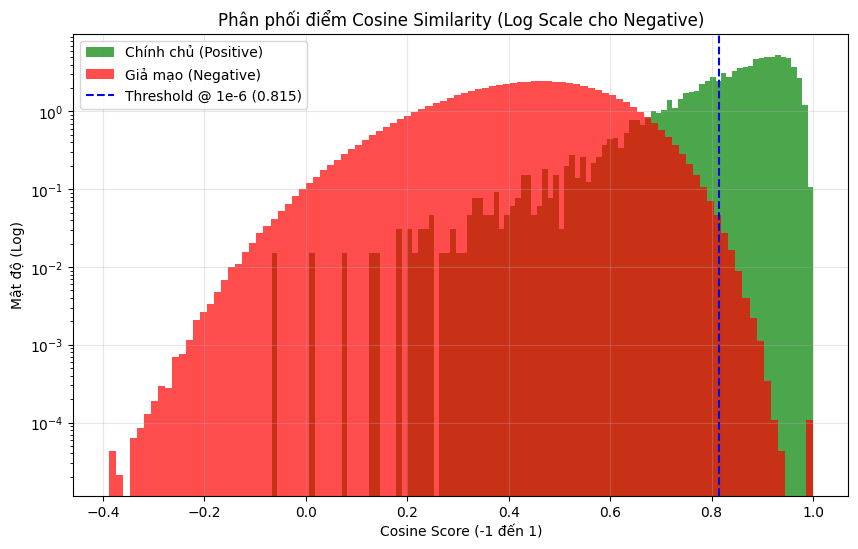

In [20]:
test_arcface(DIFF_PALM_CONFIG)

🚀 Đang trích xuất đặc trưng (Embeddings)...


100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


Đã lấy xong: torch.Size([2601, 512]) vectors.

🛡️ KẾT QUẢ BẢO MẬT (ARCFACE - COSINE SIMILARITY)
FAR Target      | Threshold (Cosine)   | TAR (Nhận đúng)
--------------------------------------------------
📊 Thống kê cặp:
   - Tổng số cặp so sánh: 3,381,300
   - Cặp chính chủ (Positive): 6,106 (Kỳ vọng điểm cao)
   - Cặp giả mạo (Negative):   3,375,194 (Kỳ vọng điểm thấp)
0.001           | 0.8544               | 51.9817%


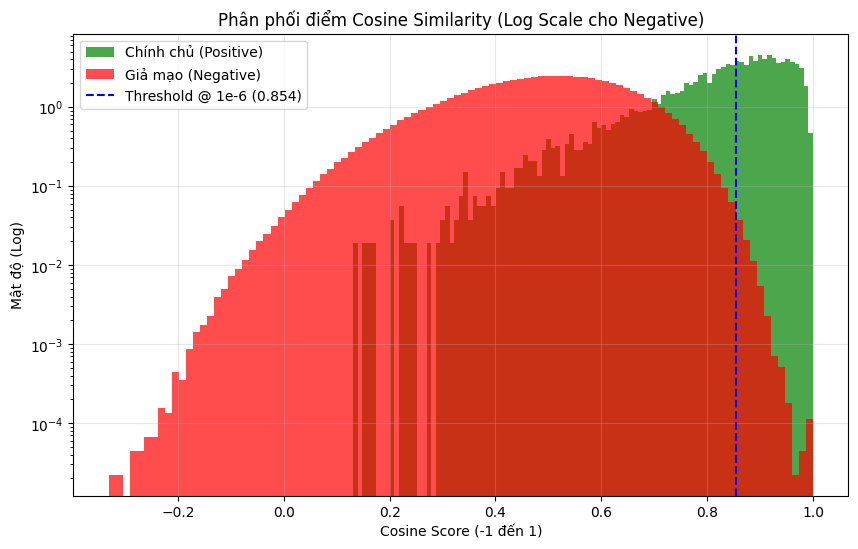

In [21]:
test_arcface(TONGJI_CONFIG)